In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
          'font.size':13,
         'figure.max_open_warning': 0}

plt.rcParams.update(params)
import matplotlib.colors as colors

In [3]:
import dask.array as da
from daskms import xds_from_table, xds_to_table
from dask.distributed import Client

import numpy as np
from astropy.time import Time
from scipy.optimize import curve_fit, minimize_scalar
from scipy import signal
from scipy.stats import chi2, shapiro

import ephem
import math
from math import degrees, acos, sin, cos, sqrt, atan2
from collections import defaultdict

In [4]:
client = Client(n_workers=4, 
                threads_per_worker=4, 
                processes=True, 
                memory_limit='8GB'
                )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39113,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:36741,Total threads: 4
Dashboard: http://127.0.0.1:35185/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:32769,


In [5]:
ds = xds_from_table("1548939342.ms")

In [6]:
for key in ds[0].keys():
    print(key)

DATA_DESC_ID
WEIGHT
TIME
PROCESSOR_ID
SCAN_NUMBER
ARRAY_ID
FEED1
FEED2
DATA
TIME_CENTROID
STATE_ID
FLAG
WEIGHT_SPECTRUM
ANTENNA2
SIGMA
ANTENNA1
IMAGING_WEIGHT
EXPOSURE
FLAG_CATEGORY
FLAG_ROW
UVW
INTERVAL
OBSERVATION_ID
FIELD_ID


In [7]:
## This is for EDA number 1

obs_table = xds_from_table("1548939342.ms::OBSERVATION")

## Code credit to Francois and Abigail ##

# Extract the observation table
obs_table_time = xds_from_table("1548939342.ms::OBSERVATION")
# print("Observation Table Keys:")
# for key in obs_table[0].keys():
    # print(f'{key}: {obs_table[0][key].values}')

# Extract observation start and end time
start_time = obs_table_time[0]["TIME_RANGE"].values[0][0]
end_time = obs_table_time[0]["TIME_RANGE"].values[0][1]

# Convert seconds to days (MJD) and then to human-readable format
start_time_days = start_time / (24 * 3600)  # Convert seconds to days
end_time_days = end_time / (24 * 3600)

# Use astropy.time.Time to convert MJD to UTC
start_time = Time(start_time_days, format='mjd').to_datetime()
end_time = Time(end_time_days, format='mjd').to_datetime()

# Print the start and end times in UTC or SAST (your local timezone)
print(f"Start Date: {start_time}")
print(f"End Date: {end_time}")

Start Date: 2019-01-31 12:56:12.122526
End Date: 2019-01-31 12:59:48.031192


In [8]:
## This is for EDA number 2

obs_table_source = xds_from_table("1548939342.ms::SOURCE")
target_obs = ""

for key in obs_table_source[0].keys():
    if key == "NAME":
        target_obs = obs_table_source[0][key].values

print("The target that was observed is", target_obs[0])

The target that was observed is PKS1934-63


In [9]:
## This is for EDA number 3

obs_table_spec = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")
bw = ""

for key in obs_table_spec[0].keys():

    if key == "TOTAL_BANDWIDTH":
        bw = obs_table_spec[0][key].values

print("The bandwidth of the observation is", bw[0]*10**-6, "MHz")

The bandwidth of the observation is 856.0 MHz


In [10]:
## This is for EDA number 4

obs_table_spec = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")
cw = ""

for key in obs_table_spec[0].keys():

    if key == "CHAN_WIDTH":
        cw = obs_table_spec[0][key].values

print("The channel width of the observation is", cw[0,0]*10**-3, "kHz")

The channel width of the observation is 835.9375 kHz


In [11]:
## This is EDA number 5

A1 = ds[0]["ANTENNA1"]
A2 = ds[0]["ANTENNA2"]
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
print(f'Total number of antennas used {nants}')


Total number of antennas used 50


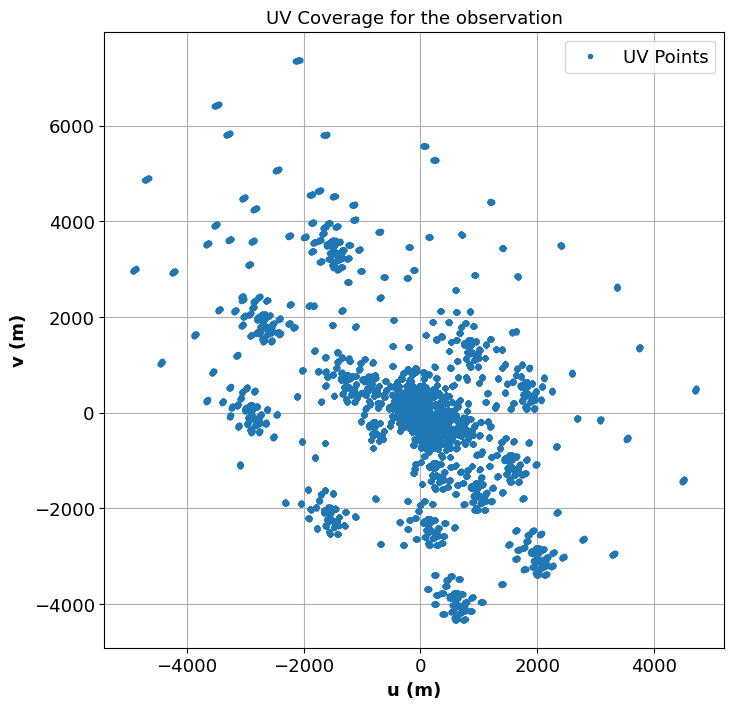

In [12]:
# Get the UVW points
u, v, w = ds[0]['UVW'][:,0], ds[0]['UVW'][:,1], ds[0]['UVW'][:,2]

# Plot the conjugate UV points
plt.figure(figsize=(8,8))
plt.plot(u, v, '.', label='UV Points')

# Labels and title
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.title('UV Coverage for the observation')
plt.legend()
plt.grid(True)

# Show the plot
# plt.savefig('UV_coverage.png')
plt.show()

In [13]:
## This is for Understanding UVW number 2

# Read the ANTENNA table
antenna_table = xds_from_table("1548939342.ms::ANTENNA")

# Extract the position values for each antenna (x, y, z)
positions = antenna_table[0]['POSITION'].values  # Assuming positions are in a (N, 3) array
antenna_names = antenna_table[0]['NAME'].values  # Antenna names

# Initialize an empty list to store the distances and corresponding antenna pairs
distances = []
baseline_dist = []

# Loop through all antennas and calculate pairwise distances
for i in range(len(positions)):
    for j in range(i + 1, len(positions)):
        # Get the position of antenna i and antenna j
        pos1 = positions[i]
        pos2 = positions[j]
        
        # Calculate the Euclidean distance
        distance = np.sqrt(np.sum((pos2 - pos1)**2))
        
        # Append the distance to the list along with the antenna indices
        distances.append((i, j, distance))

# Find the shortest and longest baseline distances
shortest_baseline = min(distances, key=lambda x: x[2])  # Find the tuple with the minimum distance
longest_baseline = max(distances, key=lambda x: x[2])   # Find the tuple with the maximum distance

# Get antenna names for the shortest and longest distances
min_ant1_name = antenna_names[shortest_baseline[0]]
min_ant2_name = antenna_names[shortest_baseline[1]]
max_ant1_name = antenna_names[longest_baseline[0]]
max_ant2_name = antenna_names[longest_baseline[1]]

# Print the calculated distances
for pair in distances:
    ## print(f"Distance between antenna {pair[0]} and antenna {pair[1]}: {pair[2]:.2f} distance units")
    baseline_dist.append(pair[2])

# Print out the shortest distance with antenna names
print(f"Shortest baseline is between antenna {min_ant1_name} and antenna {min_ant2_name} at {shortest_baseline[2]:.2f} meters")

# Print out the longest distance with antenna names
print(f"Longest baseline is between antenna {max_ant1_name} and antenna {max_ant2_name} at {longest_baseline[2]:.2f} meters")

Shortest baseline is between antenna m000 and antenna m002 at 29.26 meters
Longest baseline is between antenna m048 and antenna m060 at 7697.58 meters


In [14]:
## This is for Understanding UVW number 3 and number 4

obs_table_spec = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")

freq = obs_table_spec[0]["REF_FREQUENCY"].values

lam = (3*10**8) / freq

res_sb = 1.02 * (lam / shortest_baseline[2])
res_lb = 1.02 * (lam / longest_baseline[2])

print("Resolution of the shortest baseline is", res_sb)
print("Resolution of the longest baseline is", res_lb)

## This is for Understanding UVW number 4

time_del_sb = (shortest_baseline[2] * np.sin(90)) / (3*10**8)
time_del_lb = (longest_baseline[2] * np.sin(90)) / (3*10**8)

print("")
print("Time delay of the shortest baseline is", time_del_sb, "s")
print("Time delay of the longest baseline is", time_del_lb, "s")

Resolution of the shortest baseline is [0.0081458]
Resolution of the longest baseline is [3.09600884e-05]

Time delay of the shortest baseline is 8.718410720658206e-08 s
Time delay of the longest baseline is 2.2938702740560486e-05 s


/tmp/ipykernel_14872/601364303.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=100))


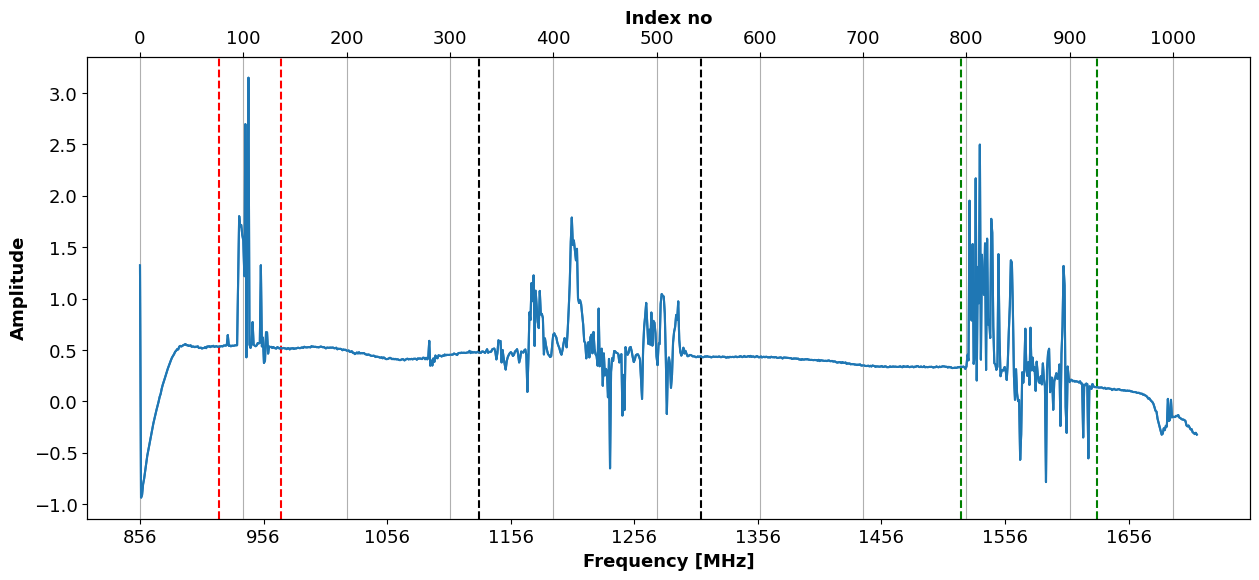

In [15]:
# This is for RFI, number 1

vis = ds[0]['DATA']

# Read the SPECTRAL table
spectral_table = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")

# Plot the average across frequency slice
frequencies = spectral_table[0]['CHAN_FREQ'].values.T
absdata = np.abs(vis[500,:,0]).compute()

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(frequencies/1.e6,np.log10(absdata),'-')
ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=100))
ax1.axvline(x=920, color='red', linestyle='--')   ## RFI region 1
ax1.axvline(x=970, color='red', linestyle='--')   ## RFI region 1
ax1.axvline(x=1130, color='black', linestyle='--')   ## RFI region 2
ax1.axvline(x=1310, color='black', linestyle='--')   ## RFI region 2
ax1.axvline(x=1520, color='green', linestyle='--')   ## RFI region 3
ax1.axvline(x=1630, color='green', linestyle='--')   ## RFI region 3
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude')

ax2.plot(np.log10(absdata))
ax2.set_xticks(np.arange(0,absdata.shape[0], step=100))
ax2.set_xlabel('Index no')
plt.grid()
# Show the plot
#plt.savefig('RFI_spectrum.png')
plt.show()

## The RFI in the region 2 is the contamination effects emitted from orbital sources in the Radio Navigational Satellite System within the 1100-1350 MHz frequency
## https://arxiv.org/html/2404.17908v1

## The RFI in region 1 is mobile phone signals (RFI CD8195 5G LTE Cellular Antenna) that were visible at 698-960 MHz
### GSM-900 uses 890 - 915 MHz to send information from the Mobile Station to the Base Transceiver Station (uplink) and 935 - 960 MHz for the other direction (downlink).
## https://www.telstat.com.au/product/rfi-cd8195-5g-mobile-antenna/

## Third region RFI is due to the Global Positioning System (GPS) satellite
## https://www.ursi.org/proceedings/2022/rfi2022/NatureandEvolutionofUHFandLbandRadioFrequencyInterferenceattheMee.pdf

Enter initial index for Gaussian fit  730
Enter final index for Gaussian fit  950


/tmp/ipykernel_14872/1968321841.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)


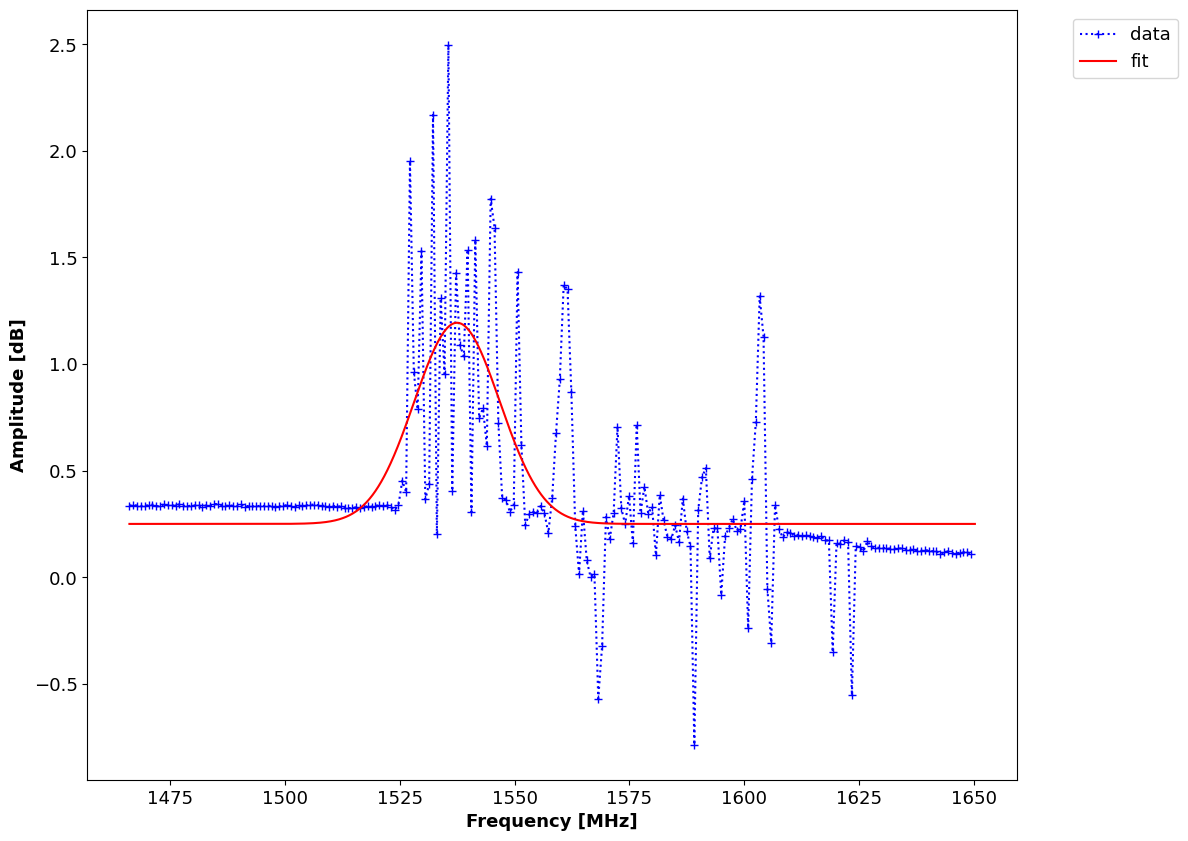

HPBW [MHz] =  97.46676199446655
Maximum amplitude is at [db], 1.1937703411320713 
Maximum is at [MHz]  1537.49525
Number of channels affected 116


In [16]:
# This is for RFI, number 6 and number 7

def Gauss(x, dc, a, x0, sigma):
    '''
    This will fit a gaussian function to a data set
    '''
    return dc+a * np.exp(-(x - x0)**2 / (2 * sigma**2))

channel_width = spectral_table[0]['CHAN_WIDTH'].values[0][0]

# Using 730-950 for Assignment 2
ini_idx = int(input('Enter initial index for Gaussian fit '))
fin_idx = int(input('Enter final index for Gaussian fit '))

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(absdata[ini_idx:fin_idx])

# weighted arithmetic mean (corrected - check the section below)
mean = (sum(x * y) / sum(y)).values
sigma = (np.sqrt(sum(y * (x - mean)**2) / sum(y))).values

dc = np.nanmean(np.log10(absdata[550:750]).values)-1

popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), dc, mean, sigma])

plt.plot(x/1e6, y, 'b+:', label='data')
x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)
plt.plot(x_new/1e6, Gauss(x_new, *popt), 'r-', label='fit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
# Show the plot
#plt.savefig('RFI_fitted.png')
plt.show()

print (f"HPBW [MHz] =  {(2.*np.sqrt(2.*np.log(2.))*sigma)/1.e6}")   ## HPBW calculation (same as FWHM for Gaussian)
print(f"Maximum amplitude is at [db], {max(Gauss(x_new, *popt))} ")
print (f"Maximum is at [MHz]  {x_new[np.argmax(Gauss(x_new, *popt))]/1.e6}")
print(f"Number of channels affected {int(((2.*np.sqrt(2.*np.log(2.))*sigma))/(channel_width))}")

In [17]:
## This is for RFI, number 8

# Assuming that we are evaluating HI transmitted at 1.575 GHz and taking the peak as 1550.8363325 MHz
f_emit = 1575
f_obs = x_new[np.argmax(Gauss(x_new, *popt))]/1.e6

z = (f_emit / f_obs) - 1
print(f"The frequency of {f_obs} MHz corresponds to a redshift of {z}")

The frequency of 1537.49525 MHz corresponds to a redshift of 0.024393408695083885


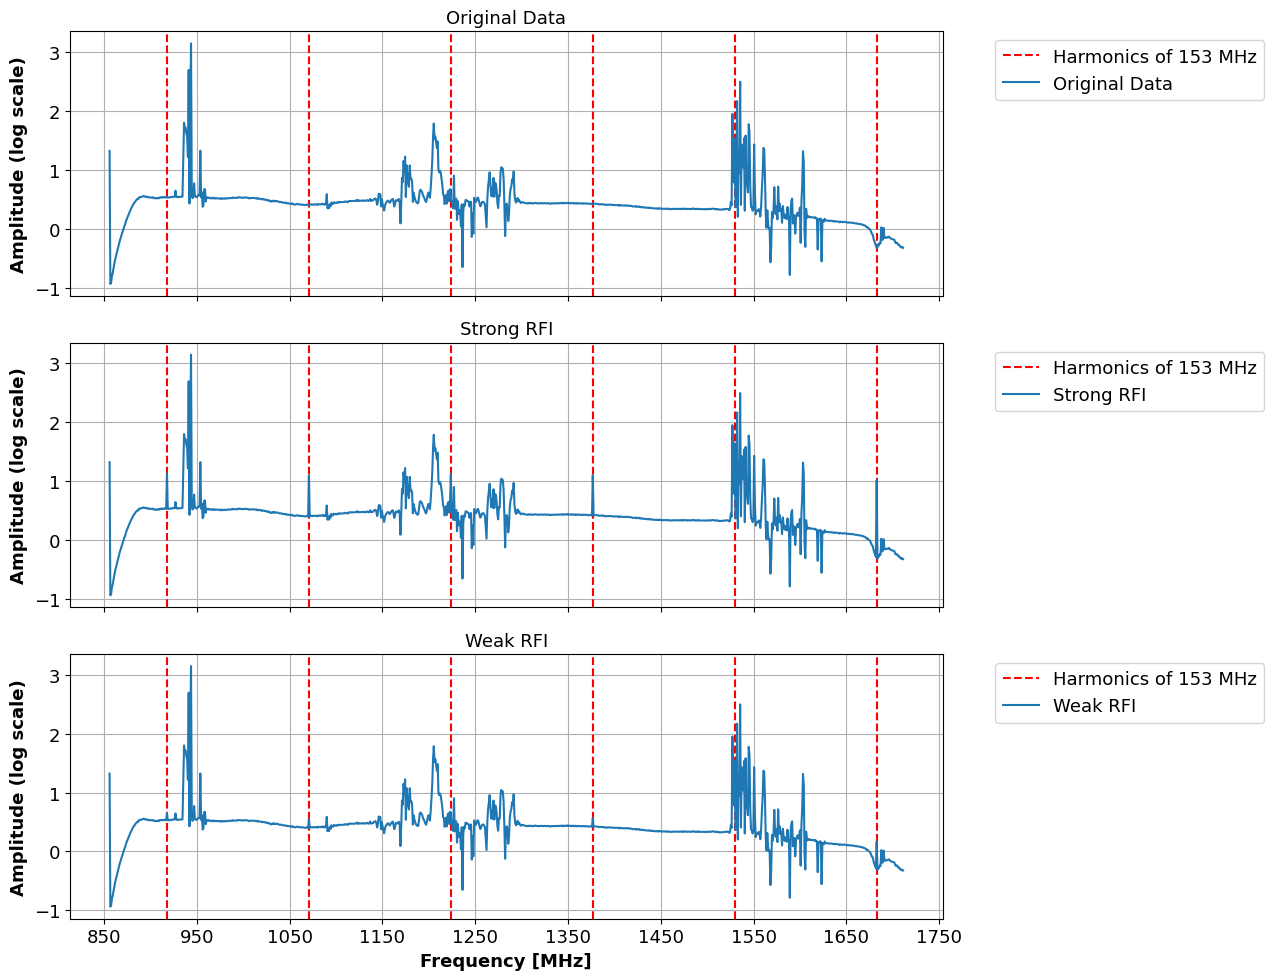

In [18]:
## This is for RFI, number 9

# Fundamental frequency
fund_freq = 153 * 10**6

# Create an array of harmonics
harmonics = np.array([6, 7, 8, 9, 10, 11])

# Multiply the fundamental frequency by the harmonics
freq_harmon = fund_freq * harmonics

# Create a figure
fig, axs = plt.subplots(nrows=3, figsize=(13, 10), sharex=True)

# Create copies for the modified data
absdata_strong = absdata.copy()
absdata_weak = absdata.copy()

# Loop through each harmonic
for i in range(len(freq_harmon)):
    harmonic_freq = freq_harmon[i]
    
    # Plot the RFI regions (harmonics)
    x = harmonic_freq / 1.e6  # Convert to MHz for the x-axis
    axs[0].axvline(x, color='red', linestyle='--', label=f'Harmonics of 153 MHz' if i == 0 else "")
    axs[1].axvline(x, color='red', linestyle='--', label=f'Harmonics of 153 MHz' if i == 0 else "")
    axs[2].axvline(x, color='red', linestyle='--', label=f'Harmonics of 153 MHz' if i == 0 else "")
    
    # Find the closest index in the frequency array to the harmonic
    closest_idx = (np.abs(frequencies - harmonic_freq)).argmin()

    # Add strong signal at harmonic locations in absdata_strong
    absdata_strong[closest_idx] += 10  # Strong signal
    
    # Add weak signal at harmonic locations in absdata_weak
    absdata_weak[closest_idx] += 1  # Weak signal

# Plot the original data
axs[0].plot(frequencies / 1.e6, np.log10(np.abs(absdata)), '-', label='Original Data')
axs[0].set_ylabel('Amplitude (log scale)')
axs[0].set_title('Original Data')
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the strong RFI data
axs[1].plot(frequencies / 1.e6, np.log10(np.abs(absdata_strong)), '-', label='Strong RFI')
axs[1].set_ylabel('Amplitude (log scale)')
axs[1].set_title('Strong RFI')
axs[1].grid(True)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the weak RFI data
axs[2].plot(frequencies / 1.e6, np.log10(np.abs(absdata_weak)), '-', label='Weak RFI')
axs[2].set_xlabel('Frequency [MHz]')
axs[2].set_ylabel('Amplitude (log scale)')
axs[2].set_title('Weak RFI')
axs[2].grid(True)
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-ticks for all subplots
axs[2].set_xticks(np.arange(850, 1770, step=100))

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
#plt.savefig('RFI_influence.png')
plt.show()

In [34]:
# This is for RFI, number 12

# Function to calculate angular separation between two celestial coordinates
def angular_separation(ra1, dec1, ra2, dec2):
    ra1_rad = ra1  # RA in radians
    dec1_rad = dec1  # Dec in radians
    ra2_rad = ra2
    dec2_rad = dec2
    
    sep_rad = acos(sin(dec1_rad) * sin(dec2_rad) + cos(dec1_rad) * cos(dec2_rad) * cos(ra1_rad - ra2_rad))
    return degrees(sep_rad)

# Function to convert Cartesian coordinates to latitude, longitude, and altitude
def cartesian_to_geodetic(x, y, z):
    r = sqrt(x**2 + y**2)
    lat = atan2(z, r)
    lon = atan2(y, x)
    alt = sqrt(x**2 + y**2 + z**2) - 6371000 
    return degrees(lat), degrees(lon), alt

def load_tle_data(tle_file):
    satellites = []
    with open(tle_file, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3):
            name = lines[i].strip()
            tle_line1 = lines[i+1].strip()
            tle_line2 = lines[i+2].strip()
            satellite = ephem.readtle(name, tle_line1, tle_line2)
            satellites.append(satellite)
    return satellites

# Set up observer location based on antenna's Cartesian coordinates
def setup_observer(observer, position):
    lat, lon, alt = cartesian_to_geodetic(position[0], position[1], position[2])
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.elevation = alt

tle_file = 'requested_TLE.txt'
satellites = load_tle_data(tle_file)

# Read the FIELD table
field = xds_from_table("1548939342.ms::FIELD")

# Define the phase center's RA and Dec
phase_center = field[0]['PHASE_DIR'].values
phase_center_ra = phase_center[0, 0, 0]
phase_center_dec = phase_center[0, 0, 1]

antenna_table_positions = antenna_table[0]['POSITION'].values
antenna_table_diam = antenna_table[0]['DISH_DIAMETER'].values

start_time = obs_table_time[0]["TIME_RANGE"].values[0][0]
end_time = obs_table_time[0]["TIME_RANGE"].values[0][1]

start_time_days = start_time / (24 * 3600)
end_time_days = end_time / (24 * 3600)

start_time = Time(start_time_days, format='mjd').to_datetime()
end_time = Time(end_time_days, format='mjd').to_datetime()

start_date = ephem.Date(start_time)
end_date = ephem.Date(end_time)

separation_threshold = 50

# Dictionary to store satellite names and their corresponding angular separations
satellite_separations = defaultdict(list)

# Loop through each antenna
for idx, position in enumerate(antenna_table_positions):

    # Create an observer for each antenna
    observer = ephem.Observer()
    setup_observer(observer, position)
    
    current_time = start_date
    
    # Loop through time range
    while current_time <= end_date:
        observer.date = current_time
        
        # Loop through satellites
        for satellite in satellites:
            satellite.compute(observer)  # Set satellite to the observer's time and location
            
            satellite_ra = satellite.ra
            satellite_dec = satellite.dec
            
            separation_deg = angular_separation(phase_center_ra, phase_center_dec, satellite_ra, satellite_dec)
            
            # Check if angular separation is below the threshold
            if separation_deg < separation_threshold:
                satellite_separations[satellite.name].append(separation_deg)

        current_time += 1 / (24 * 60)  # Move to the next minute in ephem.Date format

# After looping through all antennas and time, calculate the average separation for each satellite
satellite_avg_separations = {}

for satellite, separations in satellite_separations.items():
    if separations:  # Check if there are any separations recorded
        avg_separation = np.mean(separations)
        satellite_avg_separations[satellite] = avg_separation

# Output the result
print("Satellite Average Angular Separations:")
for satellite, avg_separation in satellite_avg_separations.items():
    print(f"{satellite}: {avg_separation:.4f} degrees")


Satellite Average Angular Separations:
BEIDOU-3 M16: 7.2446 degrees
BEIDOU-3S M1S: 29.9445 degrees
COSMOS 2529 [GLONASS-M]: 43.5104 degrees
GSAT0205 (GALILEO 9): 40.9044 degrees
COSMOS 2460 [GLONASS-M]: 35.2467 degrees
COSMOS 2475 [GLONASS-M]: 48.3601 degrees
